In [100]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
using Statistics
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")

get_params (generic function with 6 methods)

In [116]:
#load borders
border = import_border("../data/border.json")

# create the lattice grid
dx = 40
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

# define x and y coordinate for plotting
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);

In [117]:
# compute or load grid parameters
recompute_param = true

if(recompute_param || isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params_diff(isinside, isborder, Float64(dx), yrange, xrange, "../data/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5", Niter=5000, dmax = 10.0, patch=0.001, bmin=0.01)
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5")
end

0.001
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
 11.334041 seconds (696.03 M allocations: 11.592 GiB, 17.49% gc time, 1.76% compilation time)


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [118]:
trapz((yrange,xrange), m)
#contour(m,fill=true)

181.465741

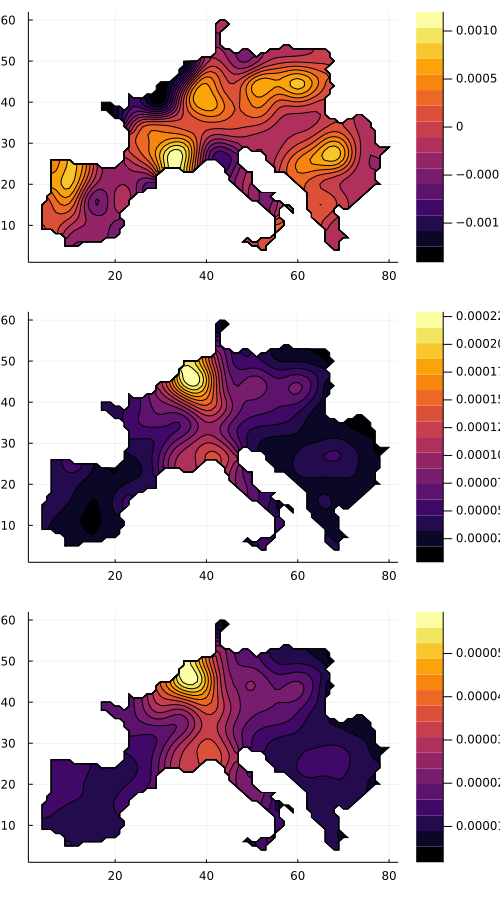

In [119]:
# plot some physical quantities
plot(do_plot(isinside, p), do_plot(isinside, m), do_plot(isinside, d), layout=(3,1), size=(500,900))


3.775344398405802e-6
1.7112495017306135e-6


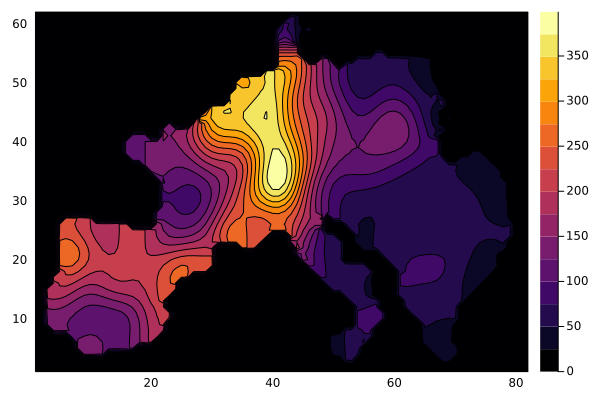

In [120]:
println(minimum(m[isinside]))
println(minimum(d[isinside]))
#bx ./= 8000
#by ./= 8000
#bx ./= 4
#by ./= 4
#bx .= max.(bx,1)
#by .= max.(by,1)
contour(by,fill=true)
#contour(by)

In [121]:
# compute, iteratively, the stable solution
interval = 1000
Niter = 15000
th = zeros(Ny, Nx)

@time begin
    for k in 1:Niter
        if(mod(k,interval) == 0)
            temp = copy(th)
        end
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j])
                    bij = (by[i-1,j] + by[i,j] + bx[i,j] + bx[i,j+1])
                    th[i,j] = (by[i,j] * th[i+1,j] + by[i-1,j] * th[i-1,j] + 
                        bx[i,j+1] * th[i,j+1] + bx[i,j] * th[i,j-1] + dx^2*p[i,j]) / bij
                end
            end
        end
        Threads.@threads for k in 1:size(n,1)
            i = Int64(n[k,1])
            j = Int64(n[k,2])
            nx = n[k,4]
            ny = n[k,3]
            if(nx == 1)
                th[i,j] = th[i,j-2]
            elseif(nx == -1)
                th[i,j] = th[i,j+2]
            end
            if(ny == 1)
                th[i,j] = th[i-2,j]
            elseif(ny == -1)
                th[i,j] = th[i+2,j]
            end
        end  
        if(mod(k,interval) == 0)
            println([k maximum(abs.(th-temp))])
        end

    end
end


[1000.0 0.0001784014553985469]
[2000.0 0.00011825015963157215]
[3000.0 0.00010281542991652515]
[4000.0 0.0001273739326417278]
[5000.0 9.446961985282165e-5]
[6000.0 0.00014281236412583276]
[7000.0 0.000106788050647455]
[8000.0 0.00010182189397056618]
[9000.0 9.893107247882504e-5]
[10000.0 8.166771211337576e-5]
[11000.0 9.565298607316919e-5]
[12000.0 7.850440734269437e-5]
[13000.0 9.877566087634904e-5]
[14000.0 7.514477464254377e-5]
[15000.0 8.641437695211529e-5]
 15.839441 seconds (704.69 M allocations: 10.626 GiB, 14.39% gc time, 0.27% compilation time)


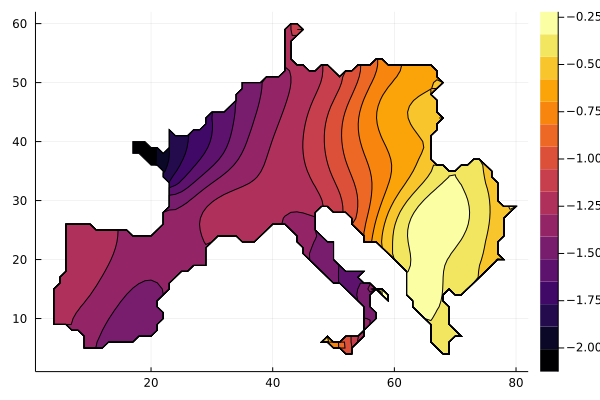

In [122]:
# plot the result
do_plot(isinside, th)
#contour(bx)

In [123]:
th2 = set_ref_phase(isinside, yrange, xrange, th, [741.57,-1078.62])

x = repeat(reshape(xrange, 1, Nx), Ny, 1)
y = repeat(reshape(yrange, Ny, 1), 1, Nx)
println(size(x))
println(size(y))
#scatter(x[isinside], y[isinside])
do_plot(isinside, th2)
savefig("cont_th.pdf")

[735.284091241364, -1069.773642941589]-0.40728297712147793
(62, 82)
(62, 82)


In [124]:
# save the result
fid = h5open("../numerics/stable_" * string(dx) * ".h5", "w")
write(fid, "th", th)
close(fid)

In [125]:
 gen, dem, bline, idb, idgen, coord, mg, dg, dl, th_ref = load_discrete_model("../data/pantagruel.h5");
println(coord[1,:])
#scatter(coord[:,1], coord[:,2])

[741.570388046061, -1078.6236630081803]


In [126]:
th_disc = get_discrete_values(yrange, xrange, th, coord);

LoadError: MethodError: no method matching get_discrete_values(::Vector{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Matrix{Float64})
[0mClosest candidates are:
[0m  get_discrete_values([91m::BitMatrix[39m, ::Vector{Float64}, [91m::Vector{Float64}[39m, ::Matrix{Float64}, [91m::Matrix{Float64}[39m) at /home/laurent/ContGridMod/scripts/tools.jl:86

In [127]:
scatter(th_disc)
scatter!(th_ref)

LoadError: UndefVarError: th_disc not defined

In [128]:
contour(get_cont_values(isinside, yrange, xrange, coord, th_ref),fill=true)
savefig("disc_th.pdf")

100
200
300
400
500
600
700
800
900
1000
  0.916168 seconds (24.74 M allocations: 434.568 MiB, 2.33% gc time, 15.34% compilation time)


In [129]:
fx, fy = power_flow(isinside, th, bx, by, Float64(dx))

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

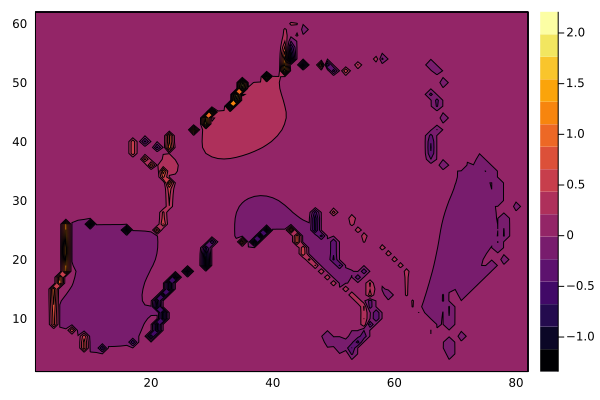

In [130]:
contour(fx, fill=true)

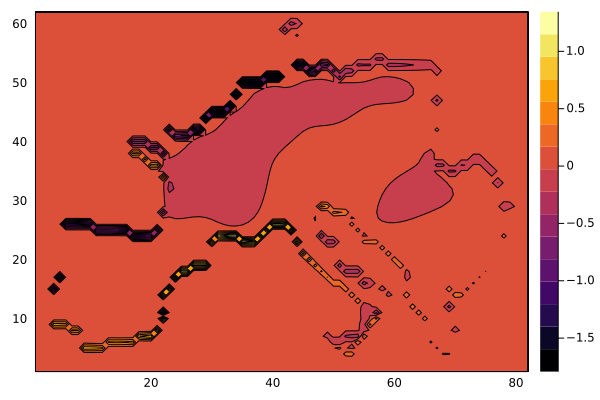

In [131]:
contour(fy, fill=true)

In [138]:

quiver(x[isinside], y[isinside], quiver=(200*fx[isinside], 200*fy[isinside]))
savefig("asdf.svg")

LoadError: unexpected vi type Nothing for quiver: nothing